# Предсказание стоимости недвижимости

[Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

Задача:
Побить свой рекорд при помощи полученных знаний

Текущий результат:

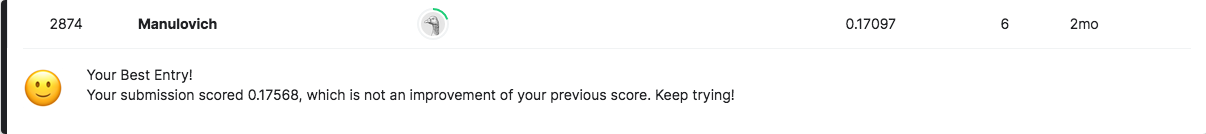

## Используемые библиотеки

In [26]:
# Для работы импорта
import sys
sys.path.append('../../')

import keras
import numpy as np
import pandas as pd
from keras import layers
from keras import Sequential
from keras import regularizers
import matplotlib.pyplot as plt
from utils import cross_validation
from sklearn.preprocessing import OneHotEncoder

## Загрузка данных

In [27]:
work_data = pd.read_csv('https://raw.githubusercontent.com/manulovich/predict-house-prices/main/data/train.csv')
prediction_data = pd.read_csv('https://raw.githubusercontent.com/manulovich/predict-house-prices/main/data/test.csv')

idx = prediction_data['Id']

## Подготовка данных

In [3]:
train_data, test_data = work_data[:1000], work_data[1000:]
x_train, y_train = train_data[train_data.columns[:-1]], train_data['SalePrice']
x_test, y_test = test_data[test_data.columns[:-1]], test_data['SalePrice']

In [4]:
def delete_signs(data: pd.DataFrame):
    signs = ['Id', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
    
    return data.drop(signs, axis=1)

In [5]:
def fill_gaps(data: pd.DataFrame, size=1000):
    data = data.copy()
    columns = data.columns
    
    for col in columns:
        if len(data[col].dropna()) >= size:
            continue
        
        if data[col].dtype == 'object':
            data[col] = data[col].fillna(data[col].replace('None', np.nan).dropna().mode()[0])
        else:
            data[col] = data[col].fillna(data[col].dropna().median())
        
    return data

In [6]:
def get_columns(data: pd.DataFrame):
    digit_columns = [col for col in data.columns if data[col].dtype != 'object']
    categorical_columns = [col for col in data.columns if data[col].dtype == 'object']
    
    return digit_columns, categorical_columns

In [7]:
def normalize(data: pd.DataFrame):
    data = data.copy()
    
    digit_columns, categorical_columns = get_columns(data)
    data[digit_columns] = (data[digit_columns] - data[digit_columns].mean()) / data[digit_columns].std()
    
    return data

In [8]:
def OHE(data: pd.DataFrame, ohe: OneHotEncoder = None):
    digit_columns, categorical_columns = get_columns(data)
    
    if ohe == None:
        ohe = OneHotEncoder(handle_unknown='ignore').fit(data[categorical_columns])
        
    result = pd.DataFrame(
        ohe.transform(data[categorical_columns]).toarray(),
        columns=list(np.concatenate(ohe.categories_).flat)
    )
    
    return data[digit_columns].join(result).fillna(0.0), ohe

In [9]:
def preparation_for_training(data: pd.DataFrame, ohe: OneHotEncoder = None):
    return OHE(normalize(fill_gaps(delete_signs(data))), ohe)

In [10]:
x_train, ohe = preparation_for_training(x_train)
x_test, _ = preparation_for_training(x_test, ohe)

## Тренировочные и валидационные данные

In [11]:
x_train, x_valid = x_train[:900], x_train[900:]
y_train, y_valid = y_train[:900], y_train[900:]

In [12]:
x_train.shape

## Конструирование сети

In [54]:
def build_model() -> Sequential:
    model = Sequential()
    
    model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='relu'))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

## Первичное обучение

In [14]:
model = build_model()

history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=1,
    validation_data=(x_valid, y_valid),
    verbose=0
)

## Контроль качества

In [15]:
history_dict = history.history

In [16]:
history_dict.keys()

In [17]:
epochs = range(len(history_dict['loss']))

plt.plot(epochs, history_dict['loss'], label='Training loss')
plt.plot(epochs, history_dict['val_loss'], label='Validation loss')
plt.title('Training and validation data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
epochs = range(len(history_dict['loss']))

plt.plot(epochs, history_dict['mae'], label='Training mae')
plt.plot(epochs, history_dict['val_mae'], label='Validation mae')
plt.title('Training and validation data')
plt.xlabel('Epochs')
plt.ylabel('Mae')
plt.legend()
plt.show()

## Обучение с кросс валидацией

In [55]:
x_data = pd.concat([x_train, x_valid])
y_data = pd.concat([y_train, y_valid])

history = cross_validation(
    x_data,
    y_data,
    build_model(),
    4,
    100
)

In [56]:
np.array(history)[:, 1].mean()

## Финальное обучение

In [57]:
model = build_model()

model.fit(
    pd.concat([x_train, x_valid]),
    pd.concat([y_train, y_valid]),
    epochs=100,
    batch_size=64,
    verbose=0
)

In [58]:
result = model.evaluate(x_test, y_test)

## Предсказание для Kaggle

In [62]:
prediction_data, _ = preparation_for_training(prediction_data, ohe)

In [63]:
result = model.predict(prediction_data)

In [64]:
solution = pd.DataFrame()
solution['Id'] = idx
solution['SalePrice'] = result

In [65]:
solution.to_csv('submission.csv', index=False)

## Вывод

Каким-то невероятным образом удалось все-таки существо улучшить качество предсказания. Кажется, что данных слишком мало. Нужно попробовать перекрестную проверку
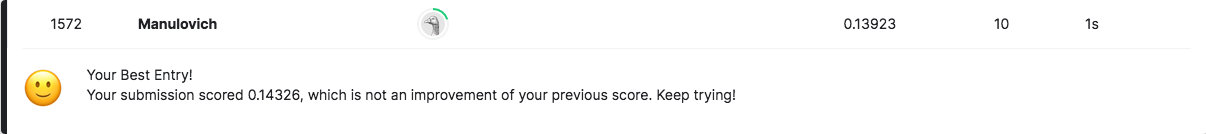

Кросс-валидация позволяет получить более объективные результаты обучение модели, но текущая реализация не позволяет набллюдать за переобучением